In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/actigraphydata/CleanedActigraphyData.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load the training data
train = pd.read_csv(base_path)
train.head(5)

,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [2]:
# Drop rows with specific participant IDs
train = train[~train['participant_id'].isin(['ab16a20d', 'db38d1f9'])]

# Check the dataset after removing the rows
train.head()


,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [3]:
# Drop the 'activity_level' column as it was introduced to understand the data
train = train.drop(columns=['activity_level','participant_id'])

In [4]:
train.head()

,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,sii
0,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,1.0
1,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,1.0
2,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,1.0
3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,0.0
4,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,0.0


In [5]:
print(train['sii'].value_counts())

sii
0.0    582
1.0    265
2.0    137
3.0     10
Name: count, dtype: int64


In [6]:
# Selecting feature columns and target variable
X = train.drop(columns=['sii'])
y = train['sii']

# Standardizing the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


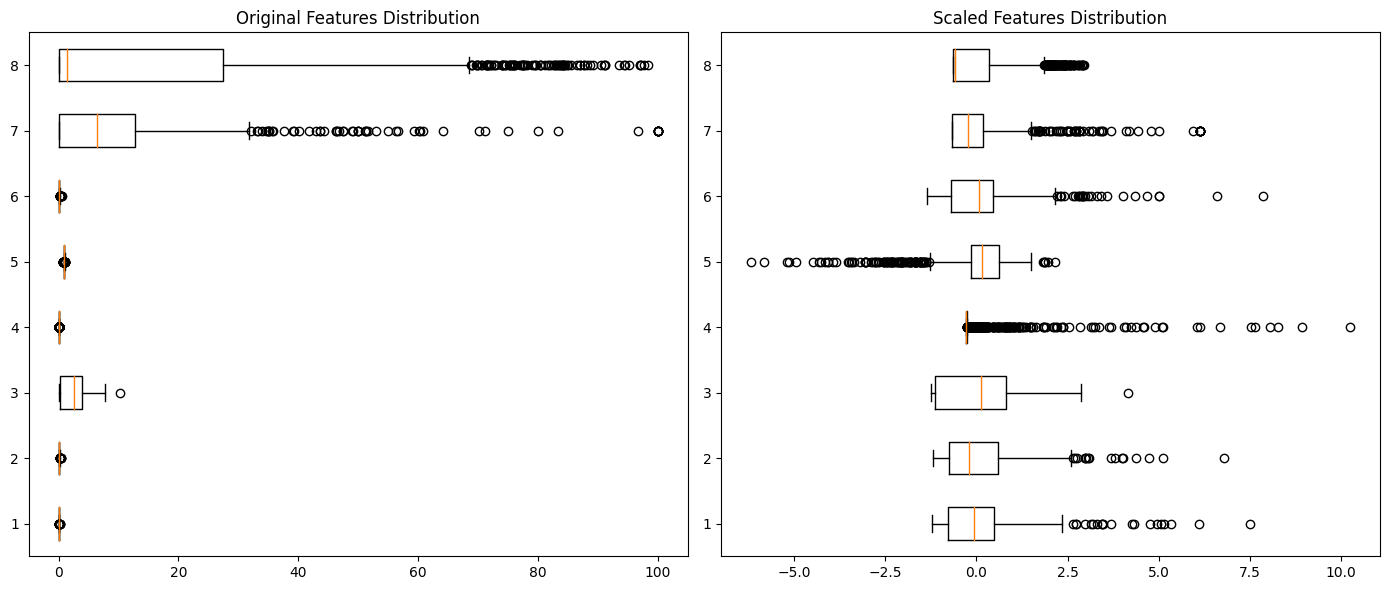

In [7]:
# Visualize original vs scaled features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before scaling
axes[0].boxplot(X.values, vert=False)
axes[0].set_title("Original Features Distribution")

# After scaling
axes[1].boxplot(X_scaled, vert=False)
axes[1].set_title("Scaled Features Distribution")

plt.tight_layout()
plt.show()


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
param_grid = {
    'C': [0.1],
    'gamma': [0.7],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.7, 'kernel': 'sigmoid'}


In [9]:
# Train SVM with best parameters
svm_model = SVC(**best_params, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=0.1, class_weight='balanced', gamma=0.7, kernel='sigmoid',
    probability=True, random_state=42)

In [10]:
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)

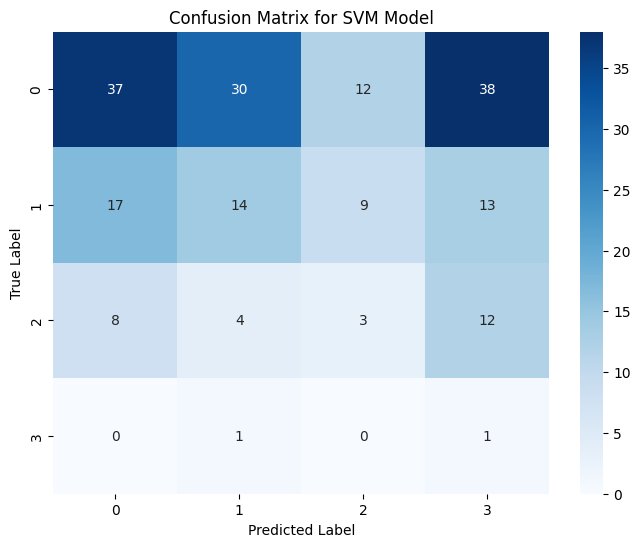

In [11]:
# Visualizing confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix for SVM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [12]:
# Evaluate the model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))


SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.32      0.41       117
         1.0       0.29      0.26      0.27        53
         2.0       0.12      0.11      0.12        27
         3.0       0.02      0.50      0.03         2

    accuracy                           0.28       199
   macro avg       0.26      0.30      0.21       199
weighted avg       0.44      0.28      0.33       199



In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import label_binarize


# Assuming data is already cleaned and preprocessed
X = train.drop(columns=[ 'sii'])
y = train['sii']

# Normalize/Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)

# PCA: Fit on the training data and transform both train and test sets
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Fit and transform on training data
X_test_pca = pca.transform(X_test)       # Transform test data using the same PCA object

# Train SVM on PCA-reduced training data
svm_model_pca = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    probability=True, 
    class_weight='balanced'
)
svm_model_pca.fit(X_train_pca, y_train)

# Predictions
y_pred = svm_model_pca.predict(X_test_pca)
y_prob = svm_model_pca.predict_proba(X_test_pca)  # Predicted probabilities for ROC-AUC

# Convert target to one-hot encoding for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_prob_binarized = y_prob

# Compute ROC AUC Score for multi-class
roc_auc = roc_auc_score(y_test_binarized, y_prob_binarized, multi_class='ovr')
print("ROC AUC Score (One-vs-Rest):", roc_auc)

# Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC AUC Score (One-vs-Rest): 0.6477335532171982
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.50      0.56       117
         1.0       0.32      0.11      0.17        53
         2.0       0.12      0.15      0.14        27
         3.0       0.00      0.00      0.00         2

    accuracy                           0.34       199
   macro avg       0.27      0.19      0.22       199
weighted avg       0.48      0.34      0.39       199

Confusion Matrix:
 [[58 10 16 33]
 [21  6 10 16]
 [11  3  4  9]
 [ 0  0  2  0]]


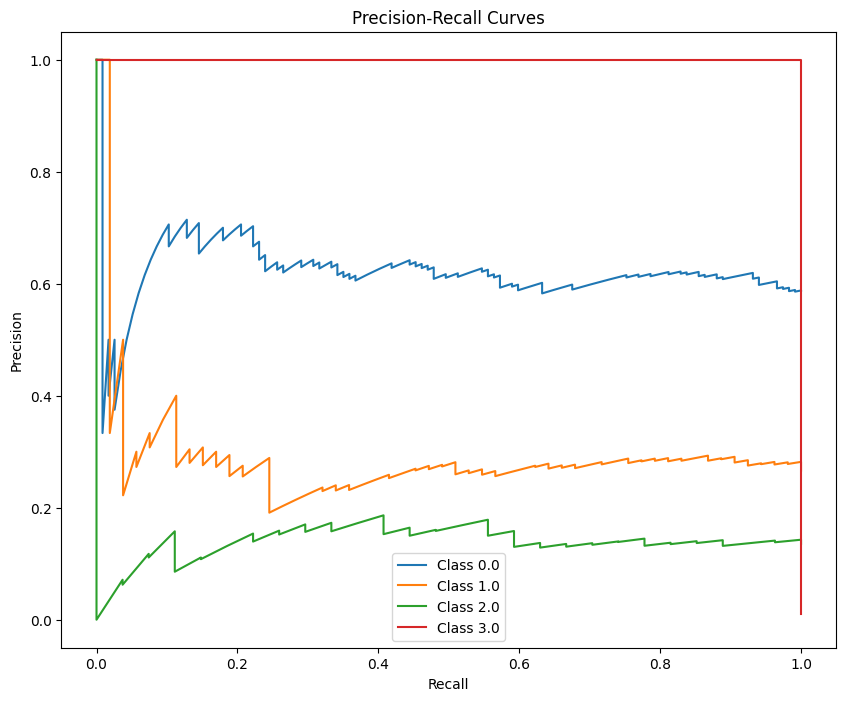

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [14]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
# Evaluate Precision-Recall and ROC Curves for each class
plt.figure(figsize=(10, 8))
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
